Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [44]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First reload the data we generated in _notmist.ipynb_.

In [45]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [46]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


### Helper methods

In [47]:
def plot_loss(x, y):
  plt.figure(figsize=(16, 4))
  plt.plot(x, y)
  plt.xlabel("Step")
  plt.ylabel("Loss")

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Logistic model + L2 Regularization

#### Stotachistic Gradient Descent

In [51]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Apply regularization
  loss += 5e-4 * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Initialized
Minibatch loss at step 0: 22.391378
Minibatch accuracy: 7.8%
Validation accuracy: 11.7%
Minibatch loss at step 500: 2.066303
Minibatch accuracy: 80.5%
Validation accuracy: 75.1%
Minibatch loss at step 1000: 1.683148
Minibatch accuracy: 77.3%
Validation accuracy: 77.6%
Minibatch loss at step 1500: 0.993433
Minibatch accuracy: 82.8%
Validation accuracy: 78.2%
Minibatch loss at step 2000: 0.896149
Minibatch accuracy: 89.8%
Validation accuracy: 79.5%
Minibatch loss at step 2500: 0.946811
Minibatch accuracy: 81.2%
Validation accuracy: 79.9%
Minibatch loss at step 3000: 0.960388
Minibatch accuracy: 79.7%
Validation accuracy: 80.8%
Test accuracy: 88.4%


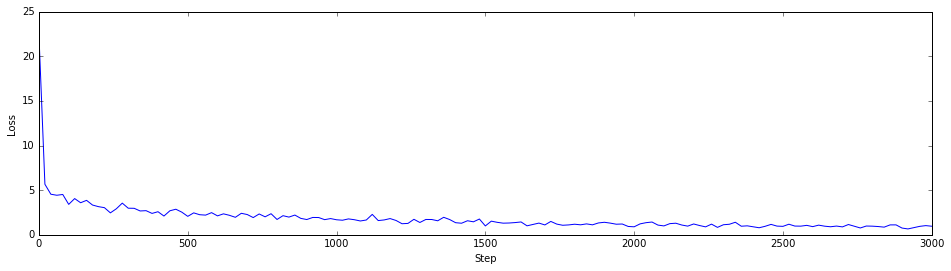

In [52]:
num_steps = 3001

xx = []
yy = []
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 20 == 0):
        xx.append(step)
        yy.append(l)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

plot_loss(xx, yy)

### Neural Network + L2 Regularization

In [55]:
batch_size = 128
hidden_units = 1024 # Size of the hidden layer

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

graph = tf.Graph()
with graph.as_default() as g:
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Hidden Layer
  with g.name_scope("hidden"):
    weights1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_units]),
        name='weights1')
    biases1 = tf.Variable(tf.zeros([hidden_units]), name='biases')
  
  # Linear
  with g.name_scope("softmax_linear"):
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_units, num_labels]),
        name='weights2')
    biases2 = tf.Variable(tf.zeros([num_labels]), name='biases')
  
  def forward_prop(inp):
    return tf.matmul(
        tf.nn.relu(tf.matmul(inp, weights1) + biases1), weights2) + biases2  

  logits = forward_prop(tf_train_dataset)

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

  # Apply regularization
  loss += 5e-4 * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)


  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(forward_prop(tf_valid_dataset))
  test_prediction = tf.nn.softmax(forward_prop(tf_test_dataset))

Initialized
Minibatch loss at step 0: 480.674194
Minibatch accuracy: 10.2%
Validation accuracy: 31.6%
Minibatch loss at step 500: 133.386307
Minibatch accuracy: 82.8%
Validation accuracy: 79.7%
Minibatch loss at step 1000: 95.983086
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 73.708351
Minibatch accuracy: 87.5%
Validation accuracy: 81.5%
Minibatch loss at step 2000: 56.283070
Minibatch accuracy: 91.4%
Validation accuracy: 83.0%
Minibatch loss at step 2500: 43.711929
Minibatch accuracy: 85.2%
Validation accuracy: 84.4%
Minibatch loss at step 3000: 33.977062
Minibatch accuracy: 84.4%
Validation accuracy: 85.1%
Test accuracy: 91.5%


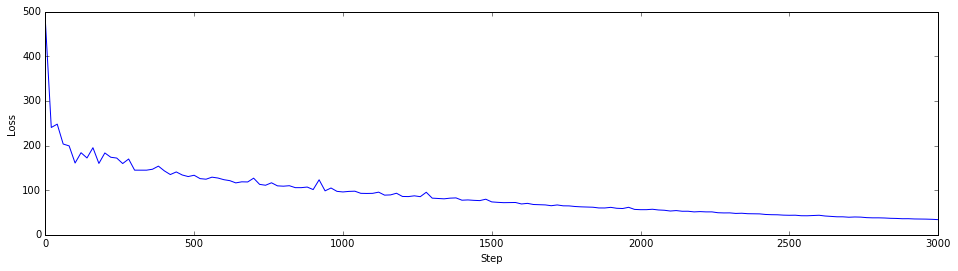

In [56]:
num_steps = 3001

xx = []
yy = []
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 20 == 0):
        xx.append(step)
        yy.append(l)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  plot_loss(xx, yy)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
